# Effect of polar displacements in formally centrosymmetric SrTiO$_3$ on resonant diffraction

Now this is a notebook to model the effect that displacements similar to the MFP phase have on the 007 Reflection near the Sr-K edge. I recommend to look first at the GeTe example where I have given more comments.

In [1]:
%matplotlib inline
import pyasf
import pylab as pl
import sympy as sp
pl.rcParams.update({'font.size':14})
from IPython.display import display, Math
print_latex = lambda x: display(Math(sp.latex(x)))

In [2]:
sto = pyasf.unit_cell("sto_bulk_80873.cif") # init the cif file, this one has quite OK Debye Waller factors
print_latex(sto.AU_positions)

Cubic


<IPython.core.display.Math object>

From databases we can only calculate the smooth part of the resonant corrections $f_1(E)$ and $f_2(E)$. The fine structure oscillations I obtained from powder EXAFS measurements and using Kramers Kronig transform. They are in these files and can be processed by pyasf...

In [3]:
Sr_f1 = pl.loadtxt("STO_Sr-f1.dat")
Sr_f2 = pl.loadtxt("STO_Sr-f2.dat")

sto.feed_feff("Sr1", Sr_f1[:,0], Sr_f1[:,1], Sr_f2[:,1])
sto.fit_feff = True # hidden switch to scale fine structure to table data... have to implement this properly

Energy = pl.linspace(15500, 16500, 1001) # energy range for simulation

We define a Symbol for the polar displacement of Ti

In [4]:
delta = sp.Symbol("delta", real=True)

This time we come from the high-symmetry .cif file. It would probably be better do load the lower Symmetry one ($P4mm$, like BaTiO3).  Therefore we now cannot modify the asymmetric unit as it restricts us to high symmetry. Instead we work on the unit cell after building...

In [5]:
sto.get_tensor_symmetry()
sto.build_unit_cell()

# indexes are: label, num in unit cell, direction (2=z)
sto.positions["O1"][0][2] += 3*delta 
sto.positions["O1"][1][2] += 3*delta
sto.positions["O1"][2][2] += 3*delta
sto.positions["Ti1"][0][2] -= delta


In [6]:
print_latex(sto.positions)

<IPython.core.display.Math object>

Here we randomly decided that the oxygen displacement is 3 times larger and opposite to the titanium displacement. It's quite close to reality but in practice we don't know that and each non-equivalent atom in the unit cell (2xOxygen and 1xTi in MFP phase) has to get an own displacement parameter. 

The number of dimensions scale rapidly with number of atoms. Such constraints as here can help to reduce dimensions. 

Let's compute the response of RXD to displacement...

In [7]:
R = 2,2,7 # choose reflection
delta_range = pl.linspace(-0.001, 0.001, 201) # choose range for displacement (lattice units)


Let's calculate the generic structure factor and use some fancy sympy printing ;-)

In [8]:
sto.calc_structure_factor() # caching all reflections
print_latex(sto.F_0)

<IPython.core.display.Math object>

U_ij are the atomic displacement parameters (due to thermal motion). Values are contained here:

In [9]:
print_latex(sto.Uiso)
print_latex(sto.Uaniso)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [10]:

Intensities = []
for delta_val in delta_range:
    sto.subs[delta] = delta_val
    F = sto.DAFS(Energy, R, force_refresh=False) # no refresh for speed
    I = abs(F)**2
    Intensities.append(I)

Intensities = pl.vstack(Intensities)

Text(0,0.5,u'Intenity')

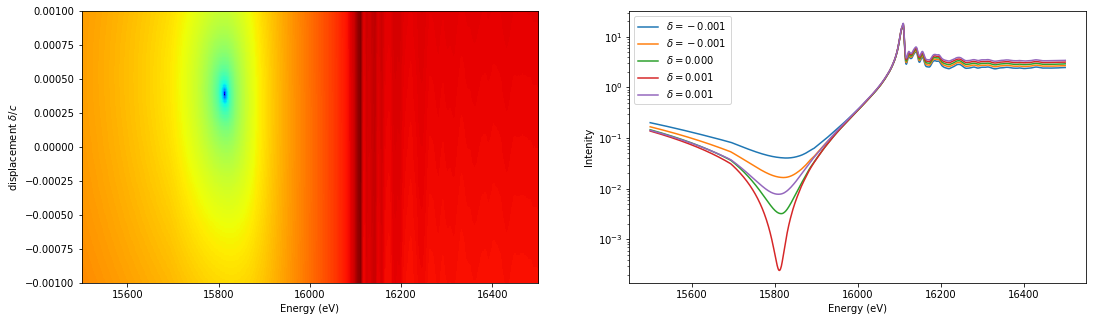

In [11]:
fig, ax = pl.subplots(1, 2, figsize=(18,5))
norm = pl.matplotlib.colors.LogNorm()
extent=(Energy[0], Energy[-1], delta_range[0], delta_range[-1])

ax[0].imshow(Intensities, norm=norm, origin="lower", extent=extent, aspect="auto", cmap=pl.cm.jet)
lines = ax[1].semilogy(Energy, Intensities[::50].T) # plot one of 50 lines
ax[1].legend(lines,  ["$\\delta=%.3f$"%val for val in delta_range[::50]])

ax[0].set_ylabel("displacement $\\delta/c$")
ax[0].set_xlabel("Energy (eV)")
ax[1].set_xlabel("Energy (eV)")
ax[1].set_ylabel("Intenity")

I hope you like this notebook. For the MFP phase, delta was roughly 0.003. A pitty that we didn't reach the -0.01 ;)

In [12]:
mu = sto.get_absorption_isotropic(Energy)

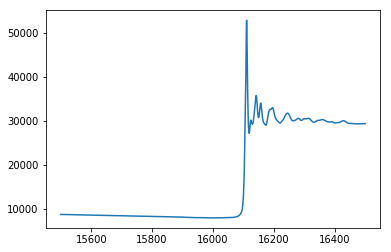

In [13]:
pl.plot(Energy, mu)

In [14]:
sto.subs[delta] = 0.003

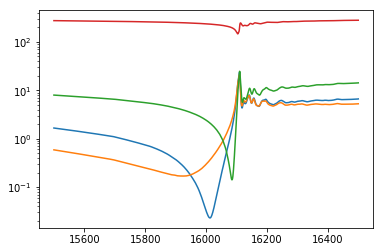

In [15]:
pl.semilogy(Energy, abs(sto.DAFS(Energy, (0,1,6)))**2)
pl.semilogy(Energy, abs(sto.DAFS(Energy, (0,2,7)))**2)
pl.semilogy(Energy, abs(sto.DAFS(Energy, (0,2,5)))**2)
pl.semilogy(Energy, abs(sto.DAFS(Energy, (0,0,6)))**2)